# Verifications of severe weather prediciton and CGAN outputs

In [ ]:
# general tools
import os
import re
import sys
import time
import h5py
import random
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
# from sklearn.metrics import auc, roc_curve, brier_score_loss, mean_squared_error
# from sklearn.metrics import confusion_matrix, classification_report, 

In [21]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [22]:
# colors_main = ['B85450', '6C8EBF', '82B366']
# colors_sub = ['F8CECC', 'DAE8FC', 'D5E8D4']
colors_sub = np.array([[248, 206, 204], [218, 232, 252], [213, 232, 212]])/255
# colors_main = np.array([[184, 84, 80], [108, 142, 191], [130, 179, 102]])/255
colors_main = [red, blue, green]

gray_main = np.array([102, 102, 102])/255
gray_sub = np.array([245, 245, 245])/255

In [23]:
# DATA_ALL = np.load('/glade/work/ksha/NCAR/GAN/TEST_2021_GAN.npy', allow_pickle=True)[()]

# BSS as functions of forecast lead times

In [24]:
# names = ['base', 'base', 'vgg2']
# prefix = ['noise', 'valid', 'valid']
tags = ['gan', 'base', 'mlp']

leads = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [25]:
temp_data = np.load('/glade/work/ksha/NCAR/GAN/TEST_2021_BSS_AUC.npy', allow_pickle=True)[()]
SCORES_ENS = temp_data['SCORES_ENS']
BSS_PLOT = temp_data['BSS_PLOT']
AUC_PLOT = temp_data['AUC_PLOT']
info = temp_data['info']

In [26]:
def setBoxColors(bp, c, m, lw, ls='-'):
    plt.setp(bp['boxes'][0], color=c, linewidth=lw, linestyle=ls)
    plt.setp(bp['caps'][0], color=c, linewidth=lw, linestyle=ls)
    plt.setp(bp['caps'][1], color=c, linewidth=lw, linestyle=ls)
    plt.setp(bp['whiskers'][0], color=c, linewidth=lw, linestyle=ls)
    plt.setp(bp['whiskers'][1], color=c, linewidth=lw, linestyle=ls)
    plt.setp(bp['medians'][0], color=m, linewidth=lw, linestyle=ls)

In [27]:
from scipy.stats import wilcoxon

def wilcoxon_by_leads(FCST1, FCST2):
    N, L = FCST1.shape
    w_stat = np.empty((L,))
    p_vals = np.empty((L,))
    
    series1 = FCST1
    series2 = FCST2
    
    for i in range(L):
        w_, p_ = wilcoxon(series1[:, i], series2[:, i],)
        w_stat[i] = w_
        p_vals[i] = p_
    return w_stat, p_vals

In [28]:
# kw_step = {'color': 'k', 'linestyle': '-', 'linewidth': 1.5, 'where':'mid'}
# kw_bar = {'bottom':0.0, 'color': '0.75', 'edgecolor': 'k', 'linestyle': '-', 'linewidth': 1.5, 'hatch': '//'}

In [29]:
# filepath_vec+'climo_severe_2hr_all.nc'

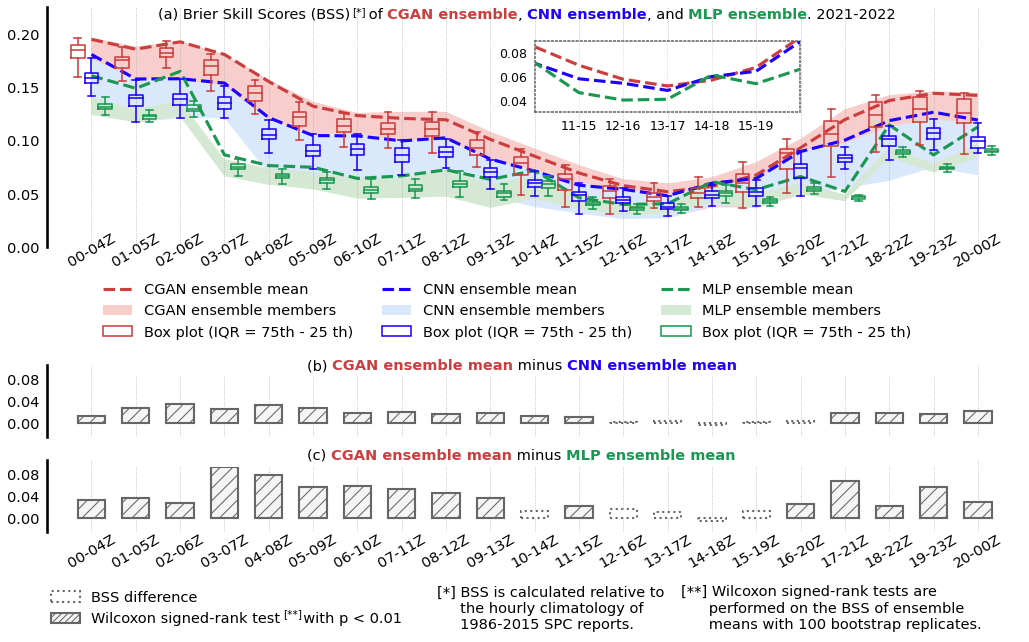

In [31]:
handles = []

fig = plt.figure(figsize=(13, 7), dpi=dpi_)

gs = gridspec.GridSpec(4, 1, height_ratios=[1, 0.3, 0.3, 0.3])#, width_ratios=[1, 0.1, 1, 0.1, 1])

ax_main = plt.subplot(gs[0, 0])
ax_gap = plt.subplot(gs[1, 0])
ax_diff1 = plt.subplot(gs[2, 0])
ax_diff2 = plt.subplot(gs[3, 0])

AX_diff = [ax_diff1, ax_diff2]

plt.subplots_adjust(0, 0, 1, 1, hspace=0.2, wspace=0.0)
ax_gap.set_axis_off()

bar_w = 0.309 #0.618
tags = ['gan', 'base', 'mlp']
#tags = ['gan',]
labels = ['CGAN ensemble mean', 'MLP ensemble mean', 'CNN baseline']

dict_c = dict(marker='o', ms=0, mew=1.5, mfc='none')

fake_x = np.empty((21, 3))
fake_x[:, 0] = np.array(leads) - bar_w
fake_x[:, 1] = np.array(leads)
fake_x[:, 2] = np.array(leads) + bar_w

for t, tag in enumerate(tags):
    for l, lead in enumerate(leads):
        # box plot
        handle_boxp = ax_main.boxplot(SCORES_ENS['{}_lead{}_BSS'.format(tag, lead)], 
                                      positions=[fake_x[l, t],], flierprops=dict_c, widths=bar_w, zorder=4)
        setBoxColors(handle_boxp, colors_main[t], colors_main[t], 1.5, ls='-')
    # color shade
    ax_main.fill_between(leads, BSS_PLOT[:, 0, t], BSS_PLOT[:, 1, t], facecolor=colors_sub[t], alpha=1, zorder=1)
    # ensemble mean
    ax_main.plot(leads, BSS_PLOT[:, 3, t], '--', lw=3.0, color=colors_main[t], label=labels[t], zorder=3)
    
    if t > 0:
        diff_ = BSS_PLOT[:, 3, 0]-BSS_PLOT[:, 3, t]
        AX_diff[t-1].bar(leads, diff_, bottom=0.0, color='w', edgecolor=gray_main, linestyle=':', linewidth=2.0, width=0.618, zorder=2)
        if t == 1:
            diff_[np.abs(diff_)<0.01] = np.nan
        else:
            diff_[np.abs(diff_)<0.02] = np.nan
        AX_diff[t-1].bar(leads, diff_, bottom=0.0, color=gray_sub, edgecolor=gray_main, linewidth=2.0, hatch='//', width=0.618, zorder=3)

# xxxxxxxxxxxxxxxxxxxxxx vvvvsdrtbhrtysjsrtjfdkmsryhjaetsjdetdukmß

ax_insert = fig.add_axes([0.5, 0.8, 0.227/5*6, 0.135])
ax_insert = gu.ax_decorate_box(ax_insert)
[j.set_color(gray_main) for j in ax_insert.spines.values()]
[j.set_linewidth(1.5) for j in ax_insert.spines.values()]
[j.set_linestyle(':') for j in ax_insert.spines.values()]

for t, tag in enumerate(tags):
    ax_insert.plot(leads, BSS_PLOT[:, 3, t], '--', lw=3.0, color=colors_main[t], label=labels[t], zorder=3)

ax_insert.set_xlim([12, 18])
ax_insert.set_ylim([0.03, 0.09]) 
ax_insert.tick_params(axis="both", which="both", labelleft=True, labelbottom=True) 
ax_insert.grid(linestyle=':', linewidth=0.5, axis='x')
ax_insert.set_xticks([13, 14, 15, 16, 17])
ax_insert.set_yticks([0.04, 0.06, 0.08])
ax_insert.set_xticklabels(['11-15', '12-16', '13-17', '14-18', '15-19'])
ax_insert.xaxis.set_tick_params(labelsize=12)
ax_insert.yaxis.set_tick_params(labelsize=12)

# xxxxxxxxxxxxxxxxxxxxxx vvvvsdrtbhrtysjsrtjfdkmsryhjaetsjdetdukmß

ax_main = gu.ax_decorate(ax_main, left_flag=True, bottom_flag=True, bottom_spline=False)
ax_diff1 = gu.ax_decorate(ax_diff1, left_flag=True, bottom_flag=False, bottom_spline=False)
ax_diff2 = gu.ax_decorate(ax_diff2, left_flag=True, bottom_flag=True, bottom_spline=False)

AX = [ax_main, ax_diff1, ax_diff2]

for ax in AX:
    ax.yaxis.grid(False)
    ax.grid(':', axis='x')
    ax.set_xlim([1, 23])
    ax.set_xticks(leads)
    
ax_main.set_ylim([0.0, 0.225])
ax_main.set_yticks([0.0, 0.05, 0.1, 0.15, 0.2])
# ax_main.set_ylabel('Brier Skill Score', fontsize=14)

AX = [ax_diff1, ax_diff2]

for i, ax in enumerate(AX):
    #ax.set_ylim([-0.025, 0.095])
    ax.set_ylim([-0.025, 0.106])
    ax.set_yticks([0.0, 0.04, 0.08])
    
AX = [ax_main, ax_diff2]
locy = [0.1, 0.1]
for i, ax in enumerate(AX):
    ax.yaxis.grid(False)
    ax.grid(':', axis='x')
    ax.set_xlim([1, 23])
    ax.set_xticks(leads)
    ax.set_xticklabels(['00-04Z', '01-05Z', '02-06Z', '03-07Z', 
                        '04-08Z', '05-09Z', '06-10Z', '07-11Z',
                        '08-12Z', '09-13Z', '10-14Z', '11-15Z',
                        '12-16Z', '13-17Z', '14-18Z', '15-19Z',
                        '16-20Z', '17-21Z', '18-22Z', '19-23Z', '20-00Z'], y=locy[i], rotation=30)


ax_title1 = fig.add_axes([0.0, 0.975, 1.0, 0.025])
ax_title1.set_axis_off()
fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal', 'bold', 'normal']
handles += gu.string_partial_format(fig, ax_title1, 2.5/22, 1.0, 'left', 'top', 
                                    ['(a) Brier Skill Scores (BSS)    of ', 'CGAN ensemble', ', ', 'CNN ensemble', ', and ', 'MLP ensemble', '. 2021-2022'], 
                                    ['k', colors_main[0], 'k', colors_main[1], 'k', colors_main[2], 'k'], fontsize_list, fontweight_list)

ax_title1.text(0.3125, 1.0, '[*]', va='top', fontsize=10, transform=ax_title1.transAxes)

ax_title2 = fig.add_axes([0.05, 0.295, 0.9, 0.035])
[j.set_linewidth(0.0) for j in ax_title2.spines.values()]
ax_title2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                      labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_title2.set_facecolor('w')
fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold']
handles += gu.string_partial_format(fig, ax_title2, 5.3/22, 1.0, 'left', 'top', 
                                    ['(b) ', 'CGAN ensemble mean', ' minus ', 'CNN ensemble mean'], 
                                    ['k', colors_main[0], 'k', colors_main[1]], fontsize_list, fontweight_list)

ax_title3 = fig.add_axes([0.05, 0.125, 0.9, 0.035])
[j.set_linewidth(0.0) for j in ax_title3.spines.values()]
ax_title3.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                      labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_title3.set_facecolor('w')
fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold']
handles += gu.string_partial_format(fig, ax_title3, 5.3/22, 1.0, 'left', 'top', 
                                    ['(c) ', 'CGAN ensemble mean', ' minus ', 'MLP ensemble mean'], 
                                    ['k', colors_main[0], 'k', colors_main[2]], fontsize_list, fontweight_list)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], linestyle='--', color=colors_main[0], linewidth=3.0, label=''))
handle_legneds1.append(patches.Patch(facecolor=colors_sub[0], edgecolor=None, label=''))
handle_legneds1.append(patches.Patch(facecolor='w', edgecolor=colors_main[0], linewidth=1.5, label=''))

handle_legneds1.append(mlines.Line2D([], [], linestyle='--', color=colors_main[1], linewidth=3.0, label=''))
handle_legneds1.append(patches.Patch(facecolor=colors_sub[1], edgecolor=None, label=''))
handle_legneds1.append(patches.Patch(facecolor='w', edgecolor=colors_main[1], linewidth=1.5, label=''))

handle_legneds1.append(mlines.Line2D([], [], linestyle='--', color=colors_main[2], linewidth=3.0, label=''))
handle_legneds1.append(patches.Patch(facecolor=colors_sub[2], edgecolor=None, label=''))
handle_legneds1.append(patches.Patch(facecolor='w', edgecolor=colors_main[2], linewidth=1.5, label=''))

ax_lg1 = fig.add_axes([0.05, 0.325, 0.85, 0.175])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handle_legneds1, ['CGAN ensemble mean',
                                      'CGAN ensemble members',
                                      'Box plot (IQR = 75th - 25 th)', 
                                      'CNN ensemble mean', 
                                      'CNN ensemble members', 
                                      'Box plot (IQR = 75th - 25 th)',
                                      'MLP ensemble mean', 
                                      'MLP ensemble members', 
                                      'Box plot (IQR = 75th - 25 th)',], 
                    bbox_to_anchor=(1, 1), ncol=3, prop={'size':14})

LG1.get_frame().set_facecolor('white')
LG1.get_frame().set_edgecolor('k')
LG1.get_frame().set_linewidth(0)

handle_legneds2 = []
handle_legneds2.append(patches.Patch(facecolor='none', edgecolor=gray_main, linewidth=2.0, linestyle=':', label='BSS difference'))
handle_legneds2.append(patches.Patch(facecolor=gray_sub, edgecolor=gray_main, linewidth=2.0, 
                                     hatch='////', label='Wilcoxon signed-rank test     with p < 0.01'))

ax_lg2 = fig.add_axes([-0.01, -0.195, 0.4, 0.1])
ax_lg2.set_axis_off()
LG2 = ax_lg2.legend(handles=handle_legneds2, bbox_to_anchor=(0.0, 0.5), ncol=1, loc=6, 
                    prop={'size':14}, fancybox=False);
LG2.get_frame().set_facecolor('none')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)

ax_lg2.text(0.63, 0.5, '[**]', va='top', fontsize=10, transform=ax_lg2.transAxes)

ax_w1 = fig.add_axes([0.4, -0.195, 0.245, 0.1])
ax_w1.set_axis_off()
ax_w1.text(0, 0.5, '[*] BSS is calculated relative to \n     the hourly climatology of\n     1986-2015 SPC reports.', 
          ha='left', va='center', fontsize=14, transform=ax_w1.transAxes);

#0.575
ax_w2 = fig.add_axes([0.65, -0.195, 0.31, 0.1])
ax_w2.set_axis_off()
ax_w2.text(0, 0.5, '[**] Wilcoxon signed-rank tests are\n      performed on the BSS of ensemble\n      means with 100 bootstrap replicates.', 
          ha='left', va='center', fontsize=14, transform=ax_w2.transAxes);

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig7_bss.png', format='png', **fig_keys)

# Reliability diagrams

In [18]:
RES_PLOT = np.load('/glade/work/ksha/NCAR/GAN/TEST_2021_RES_PLOT.npy', allow_pickle=True)[()]

In [19]:
def bs_3c(pred, frac, o, use):
    '''
    bs three components decompose
    '''
    rel = np.nansum(((pred - frac)**2)*use)/np.sum(use)
    res = np.nansum(((frac - o)**2)*use)/np.sum(use)
    return rel, res


def bss_component_calc(bs, prob_pred_mean, prob_true_mean, o_bar, use_):
    
    rel, res = bs_3c(prob_pred_mean, prob_true_mean, o_bar, use_)
    res = (o_bar)*(1-o_bar) + rel - bs
    
    return rel, res, o_bar

In [20]:
o_bars = [RES_PLOT['gan_lead2_mean'][4], RES_PLOT['gan_lead14_mean'][4], RES_PLOT['gan_lead18_mean'][4]]

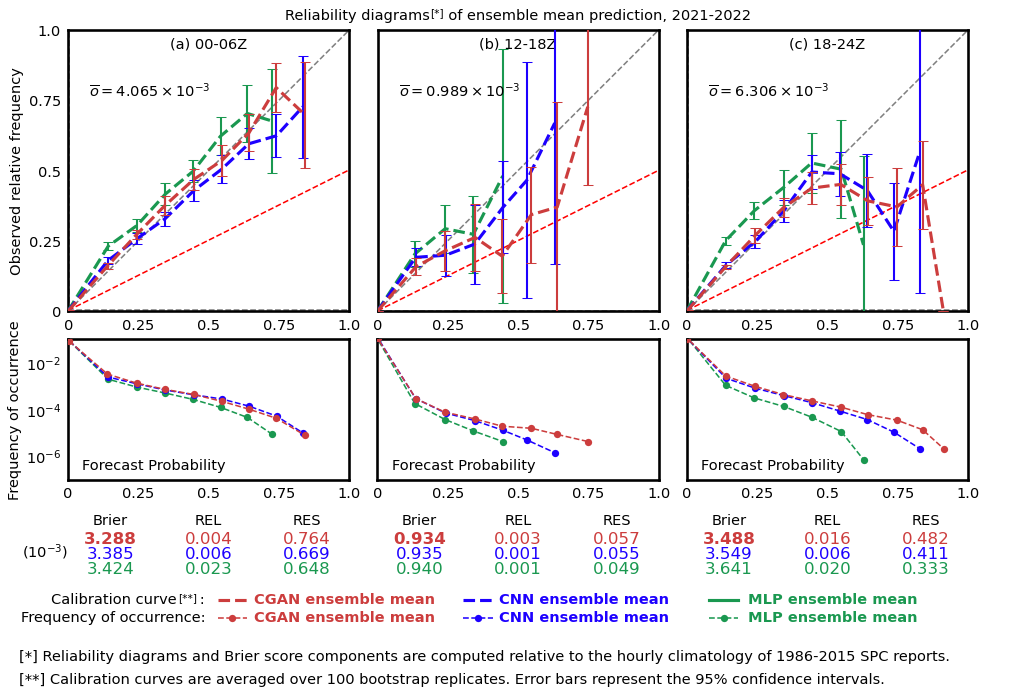

In [21]:
fig = plt.figure(figsize=(12, 7.68), dpi=dpi_)
titles = ['(a) 00-06Z', '(b) 12-18Z', '(c) 18-24Z']

handle_title = []
handle_lines = []
handle_marker = []

gs = gridspec.GridSpec(5, 5, height_ratios=[1, 0.1, 0.5, 0.15, 0.3], width_ratios=[1, 0.1, 1, 0.1, 1])

YLIM = [1e-7, 1e-1]
YLAB = [1e-6, 1e-4, 1e-2]

# no skill line
fake_x = np.linspace(0, 1, 100)
fake_y = [0.5*fake_x + 0.5*o_bars[0], 0.5*fake_x + 0.5*o_bars[1], 0.5*fake_x + 0.5*o_bars[2]]

AX_re = [] # reliability curve axis
AX_hi = [] # freq of use axis
AX_da = [] # data axis

for j in [0, 2, 4]:
    AX_re.append(plt.subplot(gs[0, j]))
    AX_hi.append(plt.subplot(gs[2, j]))
    AX_da.append(plt.subplot(gs[4, j]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)
                 
for i, ax in enumerate(AX_re):
    ax = gu.ax_decorate_box(ax)
    ax.plot(fake_x, fake_x, linewidth=1.5, linestyle='--', color='0.5')
    ax.plot(fake_x, fake_y[i], linewidth=1.5, linestyle='--', color='r')

    ax.tick_params(axis="both", which="both", labelbottom=True)
    
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
    
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0])
    
    ax.set_aspect('equal')

for i, ax in enumerate(AX_da):
    ax.set_axis_off()

for i, ax in enumerate(AX_hi):
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(axis="both", which="both", labelbottom=True)
    
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
    
    ax.set_yscale('log')
    ax.set_ylim(YLIM)
    ax.set_yticks(YLAB)
    
    ax.text(0.05, 0.05, 'Forecast Probability', ha='left', va='bottom', fontsize=14, transform=ax.transAxes)

AX_re[0].set_ylabel('Observed relative frequency', fontsize=14)
AX_hi[0].set_ylabel('Frequency of occurrence', fontsize=14)
AX_re[0].tick_params(axis="both", which="both", labelleft=True)
AX_hi[0].tick_params(axis="both", which="both", labelleft=True)


leads_start = [2, 14, 18]
tags = ['gan', 'base', 'mlp',]

label_ = ['                                      ',
          '                                      ',
          '                                      ']

for i in range(3):
    
    handle_title.append(AX_re[i].text(0.5, 0.975, titles[i], fontsize=14, ha='center', va='top', transform=AX_re[i].transAxes))
    # handle_title.append(AX_re[i].text(0.5, 0.975, titles[i], fontsize=14, ha='center', va='top', transform=AX_re[i].transAxes))
    # handle_title.append(AX_re[i].text(0.5, 0.975, titles[i], fontsize=14, ha='center', va='top', transform=AX_re[i].transAxes))
    
    AX_re[i].axvline(x=o_bars[i], ymin=0, ymax=1, linewidth=1.5, linestyle='--', color='0.5')
    AX_re[i].axhline(y=o_bars[i], xmin=0, xmax=1, linewidth=1.5, linestyle='--', color='0.5')
    
    lead_ = leads_start[i]
    
    for t, tag in enumerate(tags):

        temp_tuple = RES_PLOT['{}_lead{}_mean'.format(tag, lead_)]
        prob_true, prob_pred, hist_bins, use, o_bar, prob_pred_mean, prob_true_mean, bs = temp_tuple
        temp_95 = np.quantile(prob_true, 0.99, axis=1)
        temp_05 = np.quantile(prob_true, 0.01, axis=1)
        error = 0.5*(temp_95 - temp_05)
        AX_re[i].errorbar(prob_pred_mean, prob_true_mean, yerr=error, linestyle='--', capsize=5, 
                          color=colors_main[t], linewidth=3.0, elinewidth=2.0, zorder=5-t)
        
        # temp_tuple = RES_PLOT['{}_lead{}'.format(tag, lead_)]
        # prob_true_ens, prob_pred_ens, _, _, _, prob_pred_mean_ens, prob_true_mean_ens = temp_tuple    
        # temp_95 = np.quantile(prob_true_ens, 0.99, axis=1)
        # temp_05 = np.quantile(prob_true_ens, 0.01, axis=1)
        # error = temp_95 - temp_05
        # AX_re[i].fill_between(prob_pred_mean_ens, temp_05, temp_95, facecolor=colors_sub[t], alpha=0.5, zorder=1)
        
        handle_lines += AX_hi[i].plot(hist_bins, use/np.sum(use), color=colors_main[t], linestyle='--', 
                                      linewidth=1.5, marker='o', ms=7, mew=0, mfc=colors_main[t], label=label_[t], zorder=4-t)

# 0.004065537218164408, 0.0009891800967697548, 0.006306461894451886
    
AX_re[0].text(0.075, 0.75, r'$\overline{o} = 4.065 \times 10^{-3}$', ha='left', va='bottom', fontsize=14)
AX_re[1].text(0.075, 0.75, r'$\overline{o} = 0.989 \times 10^{-3}$', ha='left', va='bottom', fontsize=14)
AX_re[2].text(0.075, 0.75, r'$\overline{o} = 6.306 \times 10^{-3}$', ha='left', va='bottom', fontsize=14)

loc_y = [0.708, 0.53, 0.352, 0.173, 0.,]
#loc_y = [0.7, 0.4, 0.1]

table_heads = ['Brier', 'REL', 'RES']
#locx_heads = [0.25, 0.5, 0.75]
locx_heads = [0.15, 0.5, 0.85]

tags = ['gan', 'base', 'mlp']

for i in range(3):
    lead_ = leads_start[i]
    for t, tag in enumerate(tags):

        AX_da[i].text(locx_heads[t], 0.93, table_heads[t], ha='center', va='bottom', fontsize=14, transform=AX_da[i].transAxes)
        fw = 'normal'
        if i == 0:
            if tag == 'gan':
                fw = 'bold'
        if i == 1:
            if tag == 'gan':
                fw = 'bold'
        if i == 2:
            if tag == 'gan':
                fw = 'bold' 
            
        temp_tuple = RES_PLOT['{}_lead{}_mean'.format(tag, lead_)]
        prob_true, prob_pred, hist_bins, use, o_bar, prob_pred_mean, prob_true_mean, bs = temp_tuple
        rel, res, o_bar = bss_component_calc(bs, prob_pred_mean, prob_true_mean, o_bar, use)
        
        AX_da[i].text(locx_heads[0], loc_y[t], '{:.3f}'.format(1e3*bs), 
                      ha='center', va='bottom', color=colors_main[t], fontsize=16, fontweight=fw, transform=AX_da[i].transAxes)
        AX_da[i].text(locx_heads[1], loc_y[t], '{:.3f}'.format(1e3*rel), 
                      ha='center', va='bottom', color=colors_main[t], fontsize=16, transform=AX_da[i].transAxes)
        AX_da[i].text(locx_heads[2], loc_y[t], '{:.3f}'.format(1e3*res), 
                      ha='center', va='bottom', color=colors_main[t], fontsize=16, transform=AX_da[i].transAxes)

AX_da[0].text(0.0, 0.65, r'($10^{-3}$)', ha='right', va='center', fontsize=14, transform=AX_da[0].transAxes)
        
# member_names = ['CGAN\nensemble mean', 'MLP\nensemble mean', 'CNN baseline']
# for t, tag in enumerate(tags):
#     AX_da[0].text(-0.2, loc_y[t], member_names[t], ha='center', va='bottom', color=colors_main[t], 
#                   fontsize=12, fontweight='bold', transform=AX_da[0].transAxes)

# ----- legend ----- #

handle_errbar = []
handle_errbar.append(mlines.Line2D([], [], label=label_[0], linestyle='--', color=colors_main[0], linewidth=3.0,))
handle_errbar.append(mlines.Line2D([], [], label=label_[1], linestyle='--', color=colors_main[1], linewidth=3.0,))
handle_errbar.append(mlines.Line2D([], [], label=label_[2], linestyle='-', color=colors_main[2], linewidth=3.0,))

pad = 0.05
ax_box = fig.add_axes([0, -0.085+pad, 1.05, 0.0625])
ax_box.set_axis_off()

ax_lw1 = inset_axes(ax_box, height='50%', width='15%', borderpad=0, loc=2)
ax_lw2 = inset_axes(ax_box, height='50%', width='15%', borderpad=0, loc=3)
ax_lg1 = inset_axes(ax_box, height='50%', width='85%', borderpad=0, loc=1)
ax_lg2 = inset_axes(ax_box, height='50%', width='85%', borderpad=0, loc=4)

ax_lw1.text(1, 0.5, 'Calibration curve     : ', ha='right', va='center', fontsize=14, transform=ax_lw1.transAxes);
ax_lw2.text(1, 0.5, 'Frequency of occurrence: ', ha='right', va='center', fontsize=14, transform=ax_lw2.transAxes);
ax_lw1.text(0.91, 0.58, '[**]', ha='right', va='center', fontsize=10, transform=ax_lw1.transAxes);

LG = ax_lg1.legend(handles=handle_errbar, 
                   bbox_to_anchor=(0.9075, 1.5), ncol=3, prop={'size':14}, fancybox=False);
LG.get_frame().set_facecolor('none')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1.0)

LG1 = ax_lg2.legend(handles=handle_lines[0:3], 
                    bbox_to_anchor=(0.9075, 1.5), ncol=3, prop={'size':14}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

x_pad = -0.005

ax_lg1.text(0.060+x_pad, 0.875, 'CGAN ensemble mean', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=colors_main[0], transform=ax_lg1.transAxes)
ax_lg1.text(0.365+x_pad, 0.875, 'CNN ensemble mean', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=colors_main[1], transform=ax_lg1.transAxes)
ax_lg1.text(0.675+x_pad, 0.875, 'MLP ensemble mean', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=colors_main[2], transform=ax_lg1.transAxes)

ax_lg2.text(0.060+x_pad, 0.875, 'CGAN ensemble mean', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=colors_main[0], transform=ax_lg2.transAxes)
ax_lg2.text(0.365+x_pad, 0.875, 'CNN ensemble mean', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=colors_main[1], transform=ax_lg2.transAxes)
ax_lg2.text(0.675+x_pad, 0.875, 'MLP ensemble mean', ha='left', va='top', fontsize=14, fontweight='bold', 
            color=colors_main[2], transform=ax_lg2.transAxes)

ax_lw1.set_axis_off()
ax_lg1.set_axis_off()
ax_lw2.set_axis_off()
ax_lg2.set_axis_off()


ax_t1 = fig.add_axes([0.0, 1.01, 1.0, 0.03])
ax_t1.set_axis_off()
ax_t1.text(0.5, 0.5, 'Reliability diagrams    of ensemble mean prediction, 2021-2022', 
          ha='center', va='center', fontsize=14, transform=ax_t1.transAxes);

ax_t1.text(0.41, 0.7, '[*]', 
          ha='center', va='center', fontsize=10, transform=ax_t1.transAxes);

ax_w2 = fig.add_axes([-0.055, -0.155+pad, 1.065, 0.03])
ax_w2.set_axis_off()
ax_w2.text(0, 1, '[*] Reliability diagrams and Brier score components are computed relative to the hourly climatology of 1986-2015 SPC reports.', 
          ha='left', va='top', fontsize=14, transform=ax_w2.transAxes);

ax_w3 = fig.add_axes([-0.055, -0.195+pad, 1.065, 0.03])
ax_w3.set_axis_off()
ax_w3.text(0, 1, '[**] Calibration curves are averaged over 100 bootstrap replicates. Error bars represent the 95% confidence intervals.', 
          ha='left', va='top', fontsize=14, transform=ax_w3.transAxes);

# Spread-skill diagram

In [23]:
SS_group = np.load('/glade/work/ksha/NCAR/GAN/TEST_2021_spread_skill.npy', allow_pickle=True)[()]
DISCARD = np.load('/glade/work/ksha/NCAR/GAN/TEST_2021_DISCARD.npy', allow_pickle=True)[()]

In [24]:
tags = ['gan', 'base', 'mlp']
tag = tags[0]

In [25]:
lead_ = 2
temp_tuple = SS_group['{}_lead{}'.format(tag, lead_)]
prob_pred, prob_true, use_ = temp_tuple

In [26]:
diff = np.abs(prob_true - prob_pred)
SSREL = np.nansum(diff*use_/np.sum(use_))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/matplotlib/lines.py:1206: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


Text(0.0, 0.2, 'MLP ensemble')

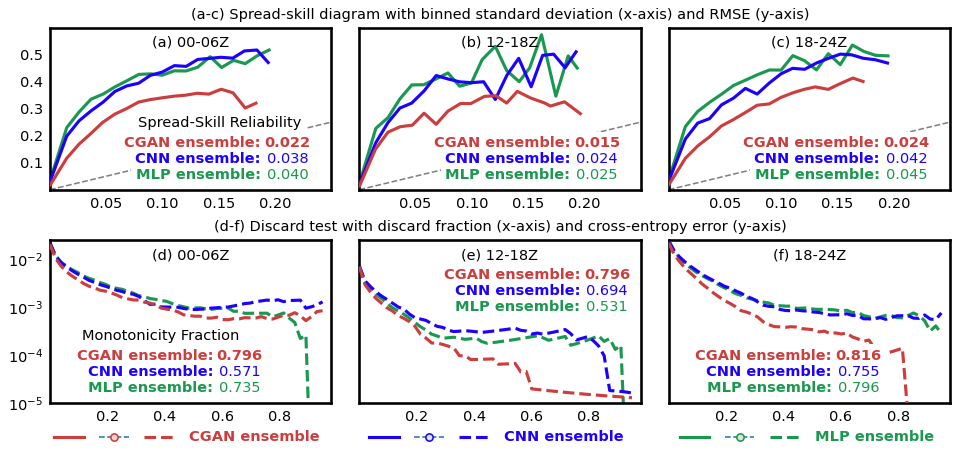

In [27]:
tags = ['gan', 'base', 'mlp']
leads_start = [2, 14, 18]

fig = plt.figure(figsize=(12, 5), dpi=dpi_)


handle_title = []
handle_lines = []
handle_marker = []

gs = gridspec.GridSpec(3, 5, height_ratios=[0.4, 0.125, 0.4], width_ratios=[1, 0.1, 1, 0.1, 1])

AX_ss = [] # reliability curve axis
AX_di = [] # data axis

for j in [0, 2, 4]:
    AX_ss.append(plt.subplot(gs[0, j]))
    AX_di.append(plt.subplot(gs[2, j]))
    
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)
      
fake_x = np.linspace(0, 1, 10)
    
for i, ax in enumerate(AX_ss):
    ax = gu.ax_decorate_box(ax)
    ax.plot(fake_x, fake_x, linewidth=1.5, linestyle='--', color='0.5')

    ax.tick_params(axis="both", which="both", labelbottom=True)
    
    ax.set_xlim([0, 0.25])
    ax.set_xticks([0, 0.05, 0.1, 0.15, 0.2,])
    ax.set_xticklabels(['', '0.05', '0.10', '0.15', '0.20'])
    
    ax.set_ylim([0, 0.6])
    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
    
    #ax.set_aspect('equal')

for i, ax in enumerate(AX_di):
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(axis="both", which="both", labelbottom=True)
    
    ax.set_xlim([0, 0.98])
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_xticklabels(['', '0.2', '0.4', '0.6', '0.8'])
    
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 0.025])
    
AX_ss[0].tick_params(labelleft=True)
AX_di[0].tick_params(labelleft=True)

title_ac = '(a-c) Spread-skill diagram with binned standard deviation (x-axis) and RMSE (y-axis)'
title_gi = '(d-f) Discard test with discard fraction (x-axis) and cross-entropy error (y-axis)'

titles_ac = ['(a) 00-06Z', '(b) 12-18Z', '(c) 18-24Z']
titles_gi = ['(d) 00-06Z', '(e) 12-18Z', '(f) 18-24Z']

handle_title.append(AX_ss[1].text(0.5, 1.125, title_ac, fontsize=14, ha='center', va='top', transform=AX_ss[1].transAxes))
handle_title.append(AX_di[1].text(0.5, 1.125, title_gi, fontsize=14, ha='center', va='top', transform=AX_di[1].transAxes))

locx_di = [0.58, 0.785, 0.58]
locy_di = [0.265, 0.765, 0.265]
d_ = 0.095
handles = []
names_ = ['CGAN ensemble', 'CNN ensemble', 'MLP ensemble']

for i in range(3):
    
    handle_title.append(AX_ss[i].text(0.5, 0.95, titles_ac[i], fontsize=14, ha='center', va='top', transform=AX_ss[i].transAxes))
    handle_title.append(AX_di[i].text(0.5, 0.95, titles_gi[i], fontsize=14, ha='center', va='top', transform=AX_di[i].transAxes))
    
    lead_ = leads_start[i]
    
    for t, tag in enumerate(tags):
        temp_tuple = SS_group['{}_lead{}'.format(tag, lead_)]
        prob_pred, prob_true, use_ = temp_tuple
        diff = np.abs(prob_true - prob_pred)
        SSREL = np.nansum(diff*use_/np.sum(use_))
        
        prob_true[0] = 0
        use_[use_==0] = 1
        AX_ss[i].plot(prob_pred[:-1], prob_true[:-1], '-', lw=3.0, color=colors_main[t], zorder=4-t)
        
        handles.append(AX_ss[i].text(0.75, 0.265-t*0.1, names_[t]+':', color=colors_main[t], ha='right', 
                                     fontsize=14, fontweight='bold', zorder=4, transform=AX_ss[i].transAxes))
        if t == 0:
            fontweight_ = 'bold'
        else:
            fontweight_ = 'normal'
            
        handles.append(AX_ss[i].text(0.75+d_, 0.265-t*0.1, '{:.3f}'.format(SSREL), color=colors_main[t], ha='center', 
                                     fontsize=14, fontweight=fontweight_, zorder=4, transform=AX_ss[i].transAxes))
        
        # =================================================== #
        
        discard_fractions, discard_error, mono_frac = DISCARD['{}_lead{}'.format(tag, lead_)]
        AX_di[i].plot(discard_fractions, discard_error, '--', lw=3.0, color=colors_main[t], zorder=4-t)
        
        handles.append(AX_di[i].text(locx_di[i], locy_di[i]-t*0.1, names_[t]+':', color=colors_main[t], ha='right', 
                                     fontsize=14, fontweight='bold', zorder=4, transform=AX_di[i].transAxes))
        
        if i == 0:
            if t == 0:
                fontweight_ = 'bold'
            else:
                fontweight_ = 'normal'
                
        else:
            if t == 0:
                fontweight_ = 'bold'
            else:
                fontweight_ = 'normal'
                
        handles.append(AX_di[i].text(locx_di[i]+d_, locy_di[i]-t*0.1, '{:.3f}'.format(mono_frac), color=colors_main[t], ha='center', 
                                     fontsize=14, fontweight=fontweight_, zorder=4, transform=AX_di[i].transAxes))

handles.append(AX_ss[0].text(0.8+d_, 0.385, 'Spread-Skill Reliability', ha='right', fontsize=14, transform=AX_ss[0].transAxes))
handles.append(AX_di[0].text(locx_di[0]+d_, 0.385, 'Monotonicity Fraction', ha='right', fontsize=14, transform=AX_di[0].transAxes))

for handle in handles:
    handle.set_bbox(dict(facecolor='w', edgecolor='w'))
        
handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], linestyle='-', color=colors_main[0], linewidth=3.0, label=''))
handle_legneds1.append(mlines.Line2D([], [], linestyle='--', linewidth=1.5, 
                                     marker='o', ms=7, mew=1.5, mec=colors_main[0], mfc=colors_sub[0], label=''))
handle_legneds1.append(mlines.Line2D([], [], linestyle='--', color=colors_main[0], linewidth=3.0, label=''))

handle_legneds2 = []
handle_legneds2.append(mlines.Line2D([], [], linestyle='-', color=colors_main[1], linewidth=3.0, label=''))
handle_legneds2.append(mlines.Line2D([], [], linestyle='--', linewidth=1.5, 
                                     marker='o', ms=7, mew=1.5, mec=colors_main[1], mfc=colors_sub[1], label=''))
handle_legneds2.append(mlines.Line2D([], [], linestyle='--', color=colors_main[1], linewidth=3.0, label=''))

handle_legneds3 = []
handle_legneds3.append(mlines.Line2D([], [], linestyle='-', color=colors_main[2], linewidth=3.0, label=''))
handle_legneds3.append(mlines.Line2D([], [], linestyle='--', linewidth=1.5, 
                                     marker='o', ms=7, mew=1.5, mec=colors_main[2], mfc=colors_sub[2], label=''))
handle_legneds3.append(mlines.Line2D([], [], linestyle='--', color=colors_main[2], linewidth=3.0, label=''))

locx = [-0.05+0.035, 0.3+0.035, 0.645+0.035]
locy = -0.08; pad = 0.17

for i in range(3):
    ax_lg1 = fig.add_axes([locx[0]+i*0.05, locy, 0.08, 0.04])
    ax_lg1.set_axis_off()
    LG1 = ax_lg1.legend([handle_legneds1[i]], [''], 
                        bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}, fontsize=0)
    LG1.get_frame().set_facecolor('white')
    LG1.get_frame().set_edgecolor('k')
    LG1.get_frame().set_linewidth(0)
    
    ax_lg2 = fig.add_axes([locx[1]+i*0.05, locy, 0.08, 0.04])
    ax_lg2.set_axis_off()
    LG2 = ax_lg2.legend([handle_legneds2[i]], [''], 
                        bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}, fontsize=0)
    LG2.get_frame().set_facecolor('white')
    LG2.get_frame().set_edgecolor('k')
    LG2.get_frame().set_linewidth(0)
        
    ax_lg3 = fig.add_axes([locx[2]+i*0.05, locy, 0.08, 0.04])
    ax_lg3.set_axis_off()
    LG3 = ax_lg3.legend([handle_legneds3[i]], [''], 
                        bbox_to_anchor=(1, 1), ncol=1, prop={'size':14}, fontsize=0)
    LG3.get_frame().set_facecolor('white')
    LG3.get_frame().set_edgecolor('k')
    LG3.get_frame().set_linewidth(0)

ax_lgtext1 = fig.add_axes([locx[0]+pad, locy, 0.15, 0.04])
ax_lgtext1.set_axis_off() 
ax_lgtext1.text(0.0, 0.2, 'CGAN ensemble', ha='left', va='top', fontsize=14, fontweight='bold', 
               color=colors_main[0], transform=ax_lgtext1.transAxes)

ax_lgtext2 = fig.add_axes([locx[1]+pad, locy, 0.15, 0.04])
ax_lgtext2.set_axis_off() 
ax_lgtext2.text(0.0, 0.2, 'CNN ensemble', ha='left', va='top', fontsize=14, fontweight='bold', 
               color=colors_main[1], transform=ax_lgtext2.transAxes)

ax_lgtext3 = fig.add_axes([locx[2]+pad, locy, 0.15, 0.04])
ax_lgtext3.set_axis_off() 
ax_lgtext3.text(0.0, 0.2, 'MLP ensemble', ha='left', va='top', fontsize=14, fontweight='bold', 
               color=colors_main[2], transform=ax_lgtext3.transAxes)

# Pattern correlation

In [32]:
R_SRH = np.load('/glade/work/ksha/NCAR/GAN/SRH_lead2.npy', allow_pickle=True)[()]
R_RADAR = np.load('/glade/work/ksha/NCAR/GAN/RADAR_DT_lead2.npy', allow_pickle=True)[()]
R_CAPE = np.load('/glade/work/ksha/NCAR/GAN/CAPE_CIN_lead2.npy', allow_pickle=True)[()]

R_plot = {}
R_plot['SRH'] = R_SRH
R_plot['RADAR'] = R_RADAR
R_plot['CAPE'] = R_CAPE

In [33]:
cmap_pct, A = gu.precip_cmap(return_rgb=True, land_map=False)

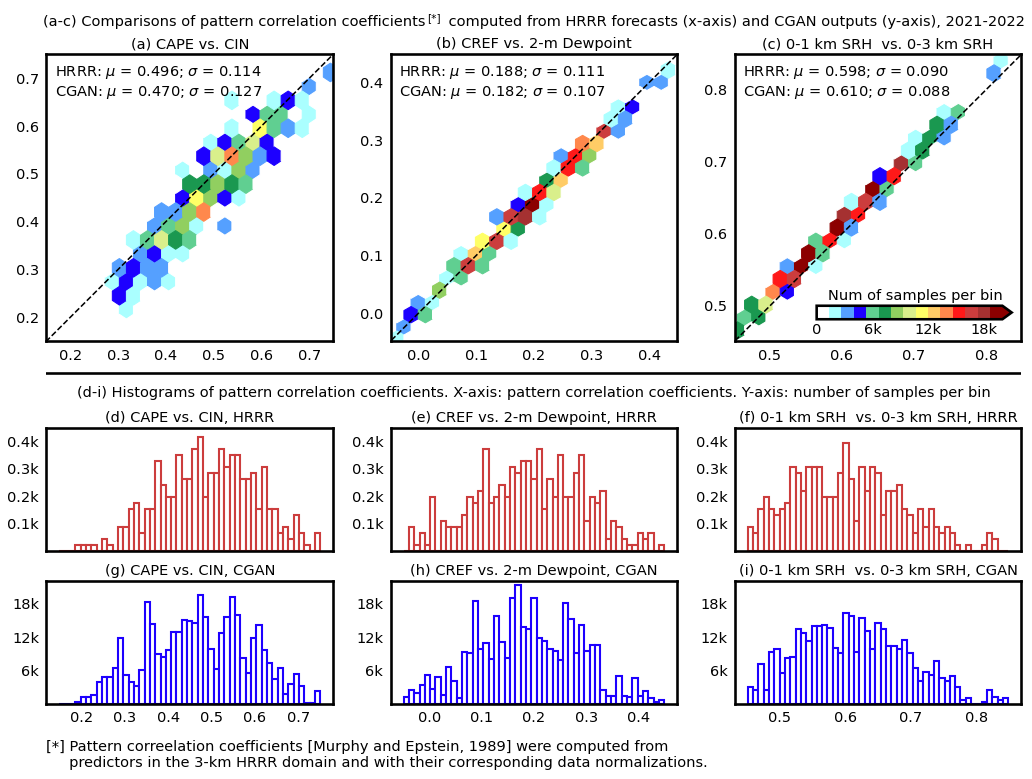

In [34]:
fig = plt.figure(figsize=(13, 9), dpi=dpi_)
gs = gridspec.GridSpec(5, 3, height_ratios=[0.55, 0.1, 0.2, 0.05, 0.2])

ax11 = plt.subplot(gs[0, 0])
ax12 = plt.subplot(gs[0, 1])
ax13 = plt.subplot(gs[0, 2])

ax21 = plt.subplot(gs[2, 0])
ax22 = plt.subplot(gs[2, 1])
ax23 = plt.subplot(gs[2, 2])

ax31 = plt.subplot(gs[4, 0])
ax32 = plt.subplot(gs[4, 1])
ax33 = plt.subplot(gs[4, 2])

ax_gap = plt.subplot(gs[1, :])
ax_gap2 = plt.subplot(gs[3, :])

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.2)

AX1 = [ax11, ax12, ax13]
AX2 = [ax21, ax22, ax23]
AX3 = [ax31, ax32, ax33]

keys = ['CAPE', 'RADAR', 'SRH']
dict_c1 = dict(marker='o', ms=8, mew=0, mec='k', mfc=colors_sub[0], zorder=1)
dict_c2 = dict(marker='o', ms=8, mew=0, mec='k', mfc=colors_sub[1], zorder=1)

LIMs = [[0.15, 0.75], [-0.049, 0.449], [0.451, 0.849]]

gsizes = [25, 25, 25]
N_bins = [20.5, 18.5, 18.5]
fake_x = np.linspace(-1, 1, 10)

titles1 = ['(d) CAPE vs. CIN, HRRR', 
           '(e) CREF vs. 2-m Dewpoint, HRRR', 
           '(f) 0-1 km SRH  vs. 0-3 km SRH, HRRR']

titles2 = ['(g) CAPE vs. CIN, CGAN', 
           '(h) CREF vs. 2-m Dewpoint, CGAN', 
           '(i) 0-1 km SRH  vs. 0-3 km SRH, CGAN']

ax11.set_title('(a) CAPE vs. CIN', fontsize=14);
ax12.set_title('(b) CREF vs. 2-m Dewpoint', fontsize=14);
ax13.set_title('(c) 0-1 km SRH  vs. 0-3 km SRH', fontsize=14);
text_gap = 0.07
    
for i in range(3):
    key = keys[i]
    ax = AX1[i]
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(axis="both", which="both", labelleft=True, labelbottom=True)
    ax.set_aspect('equal')
    ax.set_xlim(LIMs[i])
    ax.set_ylim(LIMs[i])
    if i == 2:
        ax.set_yticks([0.5, 0.6, 0.7, 0.8])
    
    R_ = R_plot[key]
    R_hrrr = np.repeat(R_['R_hrrr'][:, None], 49*22, axis=1)
    R_gan = np.repeat(R_['R_gan'][:, 1:][..., None], 22, axis=-1)
    
    # ----- 
    stats_hrrr = [np.mean(R_hrrr), np.std(R_hrrr)]
    stats_gan = [np.mean(R_gan), np.std(R_gan)]
    # KS_ = scipy.stats.kstest(R_['R_hrrr'], R_['R_gan'])
    # -----
    
    g_ = gsizes[i]
    n_ = N_bins[i]
    gsize_ = int(20*(g_/n_))
    
    CS = ax.hexbin(R_hrrr.ravel(), R_gan.ravel(), gridsize=gsize_, vmin=0, vmax=20000, cmap=cmap_pct)
    ax.plot(fake_x, fake_x, 'k--', linewidth=1.5, zorder=4)
    
    ax.text(0.03, 0.925, 'HRRR: $\mu$ = {:.3f}; $\sigma$ = {:.3f}'.format(stats_hrrr[0], stats_hrrr[1]), fontsize=14, transform=ax.transAxes)
    ax.text(0.03, 0.925-text_gap, 'CGAN: $\mu$ = {:.3f}; $\sigma$ = {:.3f}'.format(stats_gan[0], stats_gan[1]), fontsize=14, transform=ax.transAxes)
    # ax.text(0.03, 0.9-2*text_gap, 'K-S stats: {:.3f}; p: {:.3f}'.format(KS_[0], KS_[1]), fontsize=14, transform=ax.transAxes)
    
    ax2 = AX2[i]
    ax3 = AX3[i]
    ax2 = gu.ax_decorate_box(ax2)
    ax2.tick_params(axis="both", which="both", labelleft=True, labelbottom=False)
    ax3 = gu.ax_decorate_box(ax3)
    ax3.tick_params(axis="both", which="both", labelleft=True, labelbottom=True)
    
    bins = np.linspace(LIMs[i][0], LIMs[i][1], 50)
    
    ax2.hist(np.repeat(R_['R_hrrr'][:, None], 22, axis=1).ravel(), bins=bins, facecolor='w', edgecolor=colors_main[0], linewidth=2);
    ax2.set_title(titles1[i], fontsize=14)
    ax2.set_ylim([0, 450])
    ax2.set_yticks([0, 100, 200, 300, 400])
    ax2.set_yticklabels(['', '0.1k', '0.2k', '0.3k', '0.4k'])
    
    ax3.hist(R_gan.ravel(), bins=bins, facecolor='w', edgecolor=colors_main[1], linewidth=2);
    ax3.set_title(titles2[i], fontsize=14)
    ax3.set_ylim([0, 22000])
    ax3.set_yticks([0, 6000, 12000, 18000])
    ax3.set_yticklabels(['', '6k', '12k', '18k'])
    if i == 0:
        ax3.set_xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    
ax_base = fig.add_axes([0.79, 0.55, 0.2, 0.04])
[j.set_linewidth(1.0) for j in ax_base.spines.values()]
ax_base.set_axis_off()
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 6000, 12000, 18000], extend='max', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['0', '6k', '12k', '18k']);

ax13.text(0.325, 0.1825, 'Num of samples per bin', va='top', fontsize=14, transform=ax13.transAxes)

# ax11.set_ylabel('Pattern correlations computed from\nCGAN outputs (synthetic ensembles)', fontsize=14);
# ax12.set_xlabel('Pattern correlations computed from HRRR forecasts ("real" forecasts)', fontsize=14);

title_overall = '(a-c) Comparisons of pattern correlation coefficients     computed from HRRR forecasts (x-axis) and CGAN outputs (y-axis), 2021-2022'
ax12.text(0.5, 1.1, title_overall, ha='center', fontsize=14, transform=ax12.transAxes)

title_gap = '(d-i) Histograms of pattern correlation coefficients. X-axis: pattern correlation coefficients. Y-axis: number of samples per bin'
ax_gap.text(0.5, 0.5, title_gap, ha='center', fontsize=14, transform=ax_gap.transAxes)
ax_gap.axhline(y=0.9, color='k', linestyle='-', linewidth=2.5)

ax_gap.set_axis_off()
ax_gap2.set_axis_off()

ax_w2 = fig.add_axes([0.0, -0.1, 1.0, 0.05])
ax_w2.set_axis_off()
word1 = '[*] Pattern correelation coefficients [Murphy and Epstein, 1989] were computed from'
word2 = 'predictors in the 3-km HRRR domain and with their corresponding data normalizations.'
ax_w2.text(0.0, 0.5, '{}\n     {}'.format(word1, word2), ha='left', va='center', fontsize=14, transform=ax_w2.transAxes);

ax_w3 = fig.add_axes([0.3825, 1.002, 0.03, 0.03])
ax_w3.set_axis_off()
ax_w3.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=10, transform=ax_w3.transAxes);


# Feature importance

In [35]:
FI2 = np.load('/glade/work/ksha/NCAR/GAN/Feature_lead2.npy', allow_pickle=True)[()]
FI15 = np.load('/glade/work/ksha/NCAR/GAN/Feature_lead15.npy', allow_pickle=True)[()]

In [36]:
label2 = np.array(['APCP', '10-m SPD', 'CAPE', '2-5 km UH', '0-2 km UH',
                   'CREF', 'GRPL', '2-m Temp', '0-1 km SRH',
                   '0-3 km SRH', '0-6 km V shear', '0-6 km U shear', '2-m Dewpoint',
                   'CIN', 'MSLP'])

label15 = np.array(['APCP', 'CAPE', '2-5 km UH', '10-m SPD', '0-2 km UH', '0-1 km SRH',
                    'GRPL', 'CREF', '2-m Temp', '0-6 km V shear',
                    '0-3 km SRH', 'CIN', '2-m Dewpoint', '0-6 km U shear', 'MSLP'])

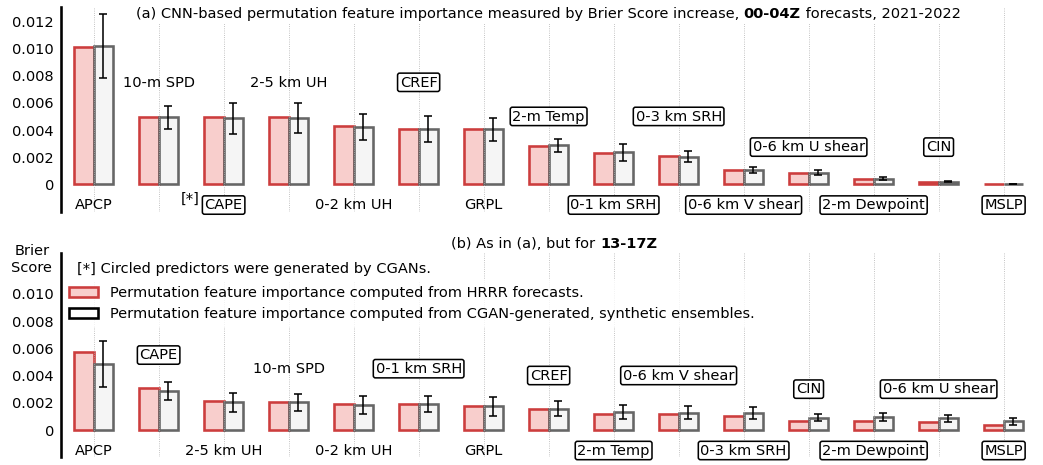

In [37]:
fig = plt.figure(figsize=(13, 6), dpi=dpi_)
gs = gridspec.GridSpec(2, 1)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])

ax1 = gu.ax_decorate(ax1, left_flag=True, bottom_flag=True)
ax2 = gu.ax_decorate(ax2, left_flag=True, bottom_flag=True)

ax1.grid(linestyle=':'); ax1.yaxis.grid(False)
ax2.grid(linestyle=':'); ax2.yaxis.grid(False)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.2, wspace=0.0)

fake_x = np.arange(15)
gap = 0.15

for i in range(15):
    fi_hrrr2 = FI2['bs_diff']
    fi_gan2 = FI2['bs_diff_gan']
    fi_gan2_mean = np.mean(fi_gan2, axis=1)
    fi_gan2_min = np.min(fi_gan2, axis=1)
    fi_gan2_max = np.max(fi_gan2, axis=1)
    
    ax1.bar(fake_x[i]-gap, fi_hrrr2[i], width=2*gap, linewidth=2.5, edgecolor=red, facecolor=colors_sub[0], capsize=5);
    ax1.bar(fake_x[i]+gap, fi_gan2_mean[i], width=2*gap, yerr=(0.5*fi_gan2_max[i]-0.5*fi_gan2_min[i]), 
             linewidth=2.5, edgecolor=gray_main, facecolor=gray_sub, capsize=4, error_kw={'markeredgewidth': 1.5});
    
    
    fi_hrrr15 = FI15['bs_diff']
    fi_gan15 = FI15['bs_diff_gan']
    fi_gan15_mean = np.mean(fi_gan15, axis=1)
    fi_gan15_min = np.min(fi_gan15, axis=1)
    fi_gan15_max = np.max(fi_gan15, axis=1)
    
    ax2.bar(fake_x[i]-gap, fi_hrrr15[i], width=2*gap, linewidth=2.5, edgecolor=red, facecolor=colors_sub[0], capsize=5);
    ax2.bar(fake_x[i]+gap, fi_gan15_mean[i], width=2*gap, yerr=(0.5*fi_gan15_max[i]-0.5*fi_gan15_min[i]), 
             linewidth=2.5, edgecolor=gray_main, facecolor=gray_sub, capsize=4, error_kw={'markeredgewidth': 1.5});
    
for ax in [ax1, ax2]:
    ax.set_xticks([14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
    ax.set_ylim([-0.002, 0.013])
    ax.set_yticks([0, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012])
    ax.set_xlim([-0.5, 14.5])
    
ax1.set_yticklabels(['0', '0.002', '0.004', '0.006', '0.008', '0.010', '0.012'])
ax2.set_yticklabels(['0', '0.002', '0.004', '0.006', '0.008', '0.010', ''])
    
fake_label = ['',]*15
    
ax1.set_xticklabels(fake_label, fontsize=14);
ax2.set_xticklabels(fake_label, fontsize=14);

# ax1.set_title('(a) Permutation feature importance measured by Brier Score increase, 00-04Z forecasts, 2021-2022', fontsize=14)
ax_title1 = fig.add_axes([0.0, 0.975, 1.0, 0.025])
ax_title1.set_axis_off()
fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal']
colors_ = ['k', 'k', 'k', 'k']
gu.string_partial_format(fig, ax_title1, 1.15/15, 1.0, 'left', 'top', 
                         ['(a) CNN-based permutation feature importance measured by Brier Score increase, ', 
                          '00-04Z', ' forecasts, 2021-2022'], 
                          colors_, fontsize_list, fontweight_list)

ax1.add_patch(patches.Rectangle((0.05, 0.92), width=0.9, height=0.08, linewidth=0, facecolor='w', transform=ax1.transAxes, zorder=8))
ax2.add_patch(patches.Rectangle((0.01, 0.86), width=0.4, height=0.14, linewidth=0, facecolor='w', transform=ax2.transAxes, zorder=8))

# for handle in handles:
#     handle.set_bbox(dict(facecolor='w', edgecolor='w'))

#ax2.set_title('(b) As in (a), but for 13-17Z forecasts', fontsize=14)

ax_title2 = fig.add_axes([0.0, 0.465, 1.0, 0.025])
ax_title2.set_axis_off()
fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold']
colors_ = ['k', 'k']
gu.string_partial_format(fig, ax_title2, 6/15, 1.0, 'left', 'top', 
                         ['(b) As in (a), but for ', '13-17Z'], 
                         colors_, fontsize_list, fontweight_list)


ax_w1 = fig.add_axes([-0.055, 0.41, 0.05, 0.06])
ax_w1.set_axis_off()
ax_w1.text(0.5, 0.5, 'Brier\nScore', ha='center', va='center', fontsize=14, transform=ax_w1.transAxes);

ax_w3 = fig.add_axes([0.1175, 0.56, 0.03, 0.03])
ax_w3.set_axis_off()
ax_w3.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=14, transform=ax_w3.transAxes);

handle_legneds1 = []
handle_legneds1.append(patches.Patch(facecolor=colors_sub[0], edgecolor=colors_main[0], linewidth=2.5, label=''))
handle_legneds1.append(patches.Patch(facecolor='w', edgecolor='k', linewidth=2.5, label=''))

ax_w2 = fig.add_axes([0.0+0.01, -0.095+0.49, 0.375, 0.05])
ax_w2.set_axis_off()
ax_w2.text(0.5, 0.5, '[*] Circled predictors were generated by CGANs.', 
           ha='center', va='center', fontsize=14, transform=ax_w2.transAxes);

ax_lg1 = fig.add_axes([0.0+0.01, -0.195+0.49, 0.715, 0.115])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handle_legneds1, ['Permutation feature importance computed from HRRR forecasts.', 
                                      'Permutation feature importance computed from CGAN-generated, synthetic ensembles.'], 
                    bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})

LG1.get_frame().set_facecolor('white')
LG1.get_frame().set_edgecolor('k')
LG1.get_frame().set_linewidth(0)


# ----- y-axis labels ----- #

gan_var = ['CAPE', 'CREF', '2-m Temp', '0-1 km SRH','0-3 km SRH', 
           '0-6 km V shear', '0-6 km U shear', '2-m Dewpoint', 'CIN', 'MSLP']

y_loc = -0.001
pad = 0.0

for i in range(15):
    if i%2 == 0:
        y_ = y_loc
    if i in [1, 3, 5]:
        y_ = 0.008
    if i in [7, 9]:
        y_ = 0.0055
    if i in [11, 13]:
        y_ = 0.00325

    if label2[i] in gan_var:
        ax1.text(fake_x[i]+pad, y_, label2[i], ha='center', va='top', fontsize=14,
                 bbox=dict(facecolor='w', edgecolor='black', linewidth=1.5, boxstyle='round,pad=0.15'))
    else:
        ax1.text(fake_x[i]+pad, y_, label2[i], ha='center', va='top', fontsize=14)
    
    if i%2 == 0:
        y_ = y_loc
    if i == 1:
        y_ = 0.006
    if i in [3, 5]:
        y_ = 0.005
    if i in [7, 9]:
        y_ = 0.0045
    if i in [11, 13]:
        y_ = 0.0035
    
    if label15[i] in gan_var:
        ax2.text(fake_x[i]+pad, y_, label15[i], ha='center', va='top', fontsize=14,
                 bbox=dict(facecolor='w', edgecolor='black', linewidth=1.5, boxstyle='round,pad=0.15'))
    else:
        ax2.text(fake_x[i]+pad, y_, label15[i], ha='center', va='top', fontsize=14)

# Training loss (presentation only)

In [38]:
temp_data11 = np.load('/glade/work/ksha/NCAR/Keras_models/LOSS_GAN_gen1_skew.npy', allow_pickle=True)[()]
temp_data12 = np.load('/glade/work/ksha/NCAR/Keras_models/LOSS_GAN_gen2_skew.npy', allow_pickle=True)[()]
temp_data13 = np.load('/glade/work/ksha/NCAR/Keras_models/LOSS_GAN_gen3_skew.npy', allow_pickle=True)[()]

In [39]:
temp_data21 = np.load('/glade/work/ksha/NCAR/Keras_models/LOSS_GAN_gen1_skew_wild.npy', allow_pickle=True)[()]
temp_data22 = np.load('/glade/work/ksha/NCAR/Keras_models/LOSS_GAN_gen2_skew_wild.npy', allow_pickle=True)[()]
temp_data23 = np.load('/glade/work/ksha/NCAR/Keras_models/LOSS_GAN_gen3_skew_wild.npy', allow_pickle=True)[()]

In [40]:
recon_loss = np.concatenate((temp_data11['GAN_LOSS'][:128, 1], 
                             temp_data12['GAN_LOSS'][:, 1], 
                             temp_data13['GAN_LOSS'][:, 1],
                             temp_data21['GAN_LOSS'][:128, 1], 
                             temp_data22['GAN_LOSS'][:, 1], 
                             temp_data23['GAN_LOSS'][:, 1]), axis=0)

adv_loss = np.concatenate((temp_data11['GAN_LOSS'][:128, 2], 
                           temp_data12['GAN_LOSS'][:, 2], 
                           temp_data13['GAN_LOSS'][:, 2],
                           temp_data21['GAN_LOSS'][:128, 2], 
                           temp_data22['GAN_LOSS'][:, 2], 
                           temp_data23['GAN_LOSS'][:, 2]), axis=0)

Text(0.3, 0.75, 'Adversarial loss (cross-entropy)')

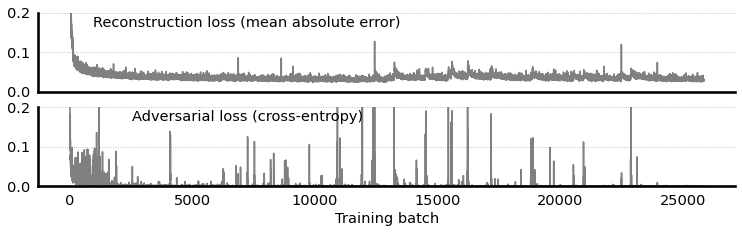

In [41]:
fig = plt.figure(figsize=(12, 3), dpi=dpi_)

gs = gridspec.GridSpec(2, 1)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])

AX = [ax1, ax2]
for ax in AX:
    ax = gu.ax_decorate(ax, left_flag=True, bottom_flag=False, bottom_spline=True)
    ax.set_ylim([0.0, 0.20])
    
ax2.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)
ax2.set_xlabel('Training batch', fontsize=14)


ax1.plot(recon_loss, color='0.5')
ax2.plot(adv_loss, color='0.5')

ax1.set_title('Reconstruction loss (mean absolute error)', x=0.3, y=0.75, fontsize=14)
ax2.set_title('Adversarial loss (cross-entropy)', x=0.3, y=0.75, fontsize=14)